In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

%load_ext autoreload
%autoreload 2

import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate
from scipy import spatial, signal
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
# import importlib
from IPython.display import display, HTML
import pandas as pd
import pickle
import re
from scanf import scanf

import matplotlib
# matplotlib.use('agg')
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm
from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb
import spectrum

# %matplotlib notebook
%matplotlib inline
rc('animation', html='html5')
fontsize = 40
PWD = os.getcwd()

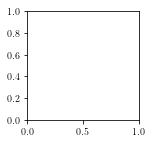

In [2]:
fig = plt.figure(figsize=(2, 2))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1)

In [3]:
job_dir = 'ecoC01B05_passive_psi-0a'
# table_name = 'ecoC01B05_tao1_wm0'
t_headle = '(.*?).pickle'

-ini_theta 0.142800 -ini_phi 6.283185 -ini_psi 0.000000


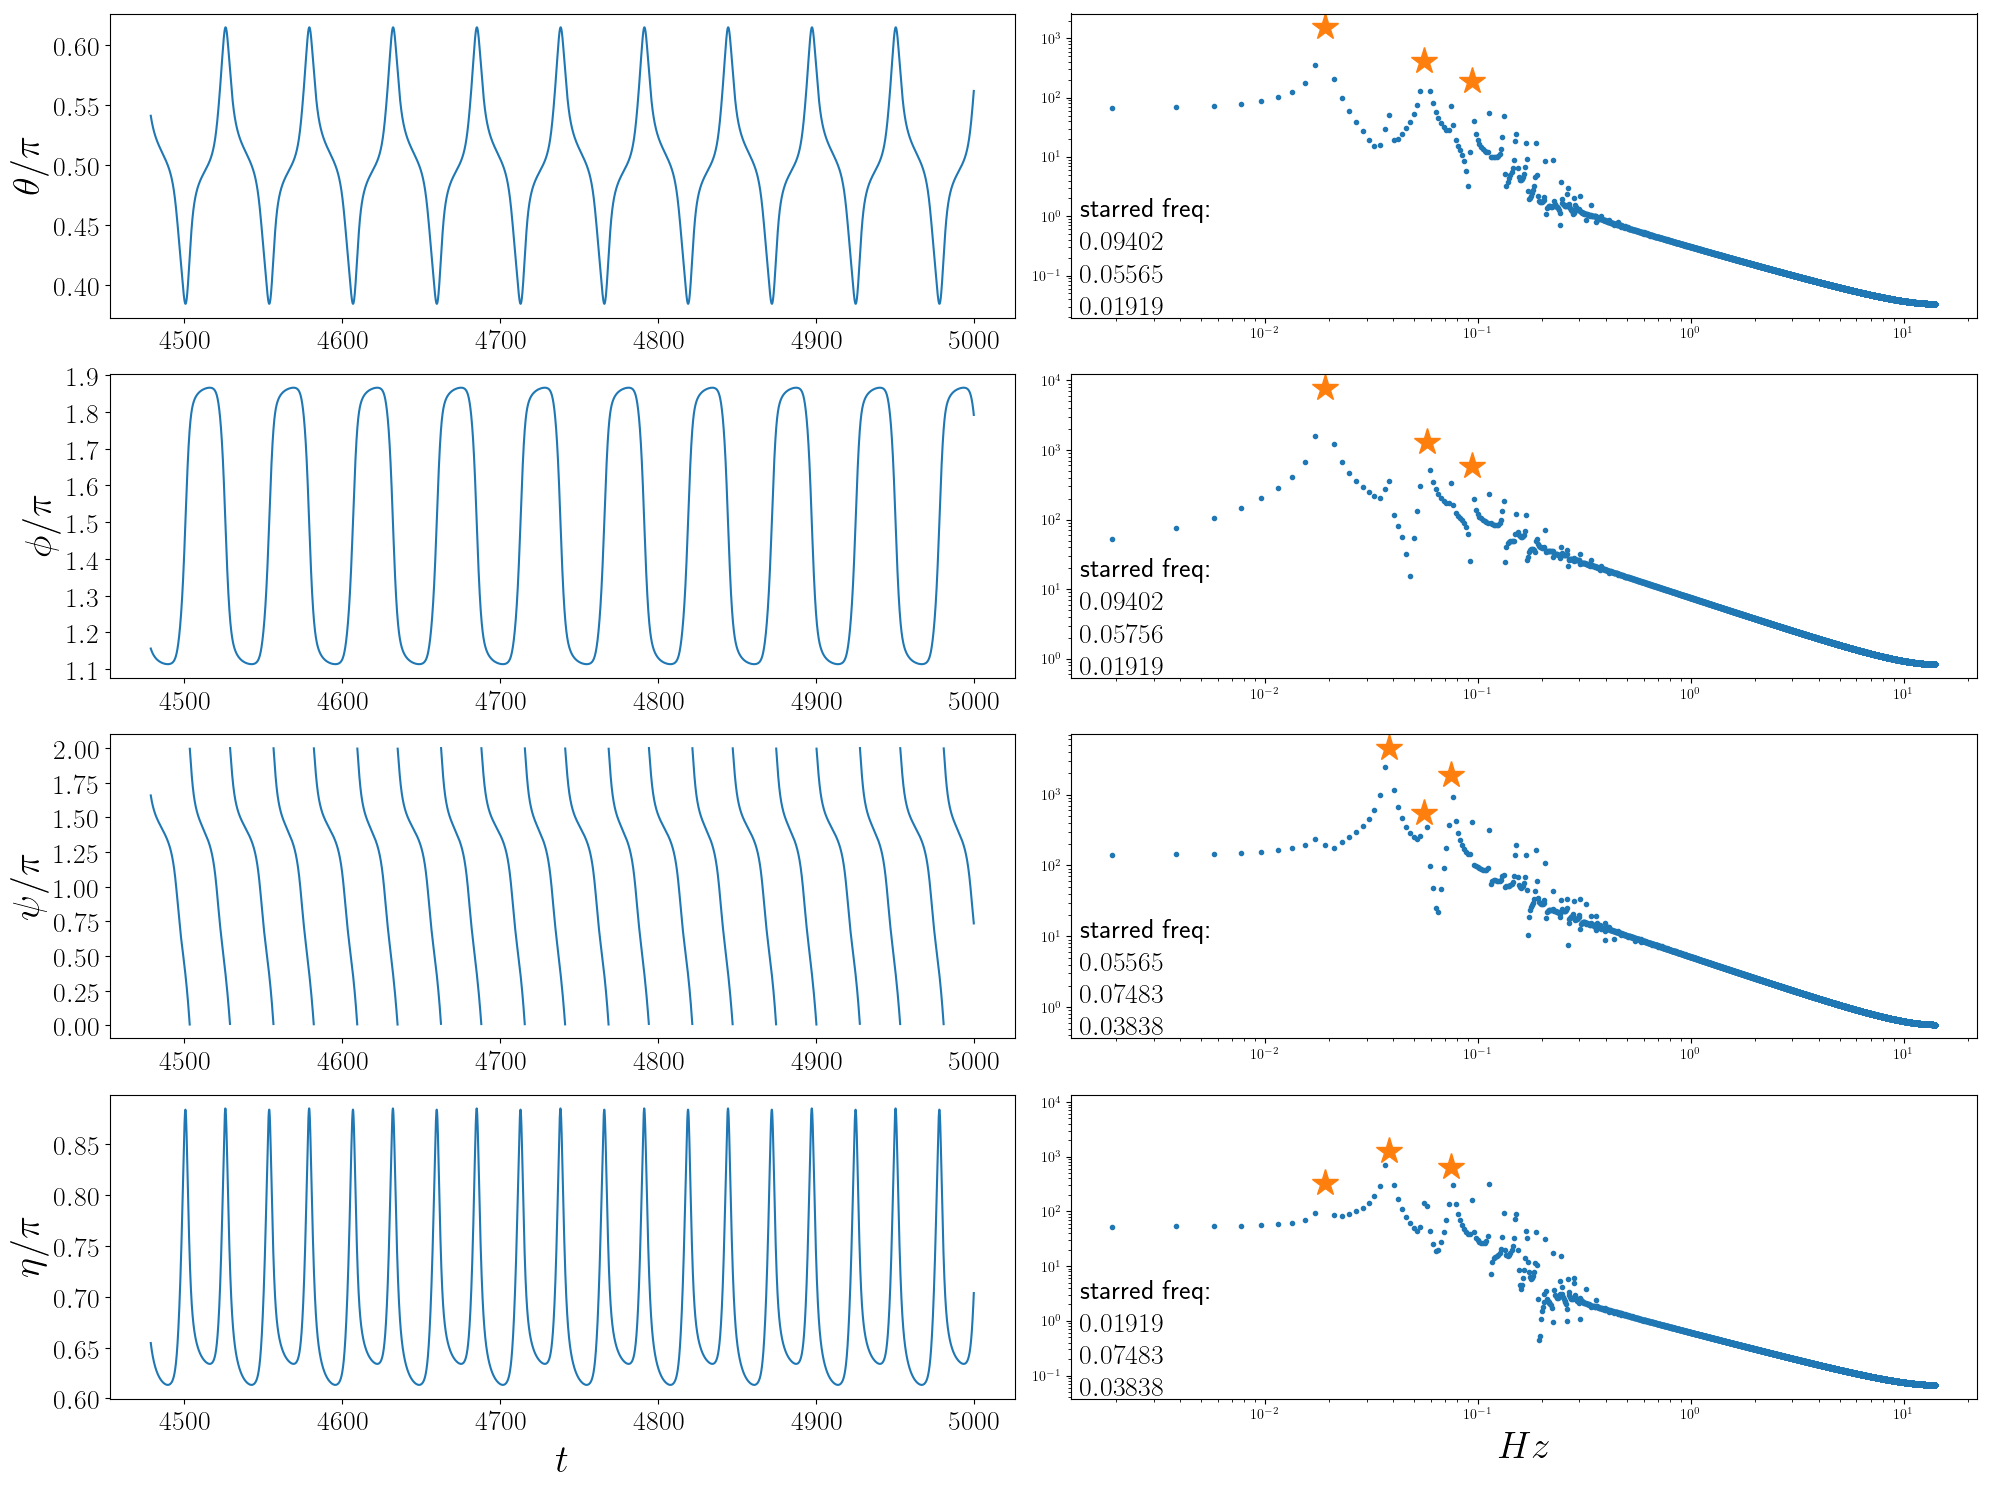

In [4]:
theta, phi = 0.0000, 1.714
theta, phi = 0.1430, 0.000

tpick, _ = spf_tb.load_table_date_pickle(job_dir, theta, phi)
Table_t = tpick['Table_t']
Table_dt = tpick['Table_dt']
Table_X = tpick['Table_X']
Table_P = tpick['Table_P']
Table_P2 = tpick['Table_P2']
Table_theta = tpick['Table_theta']
Table_phi = tpick['Table_phi']
Table_psi = tpick['Table_psi']
Table_eta = tpick['Table_eta']
print('-ini_theta %f -ini_phi %f -ini_psi %f' % 
      (tpick['Table_theta'][0], tpick['Table_phi'][0], tpick['Table_psi'][0]))

freq_pk = spf_tb.get_major_fre(Table_t, Table_theta)
idx = Table_t > Table_t.max() - 1 / freq_pk * 10
# spf_tb.show_table_result(Table_t[idx], Table_dt[idx], Table_X[idx], Table_P[idx], Table_P2[idx], 
#                          Table_theta[idx], Table_phi[idx], Table_psi[idx], Table_eta[idx], save_every)
# spf_tb.show_theta_phi(Table_t[idx], Table_dt[idx], Table_X[idx], Table_P[idx], Table_P2[idx], 
#                       Table_theta[idx], Table_phi[idx], Table_psi[idx], Table_eta[idx], show_back_direction=False)
spf_tb.show_theta_phi_psi_eta(Table_t[idx], Table_dt[idx], Table_X[idx], Table_P[idx], Table_P2[idx], 
                              Table_theta[idx], Table_phi[idx], Table_psi[idx], Table_eta[idx])
# spf_tb.show_center_X(Table_t[idx], Table_dt[idx], Table_X[idx], Table_P[idx], Table_P2[idx], 
#                      Table_theta[idx], Table_phi[idx], Table_psi[idx], Table_eta[idx], 
#                      table_name=table_name)

_ = spf_tb.resampling_data(Table_t, Table_dt, Table_X, Table_P, Table_P2,
                           Table_theta, Table_phi, Table_psi, Table_eta, resampling_fct=2)
Table_t, Table_dt, Table_X, Table_P, Table_P2, Table_theta, Table_phi, Table_psi, Table_eta = _

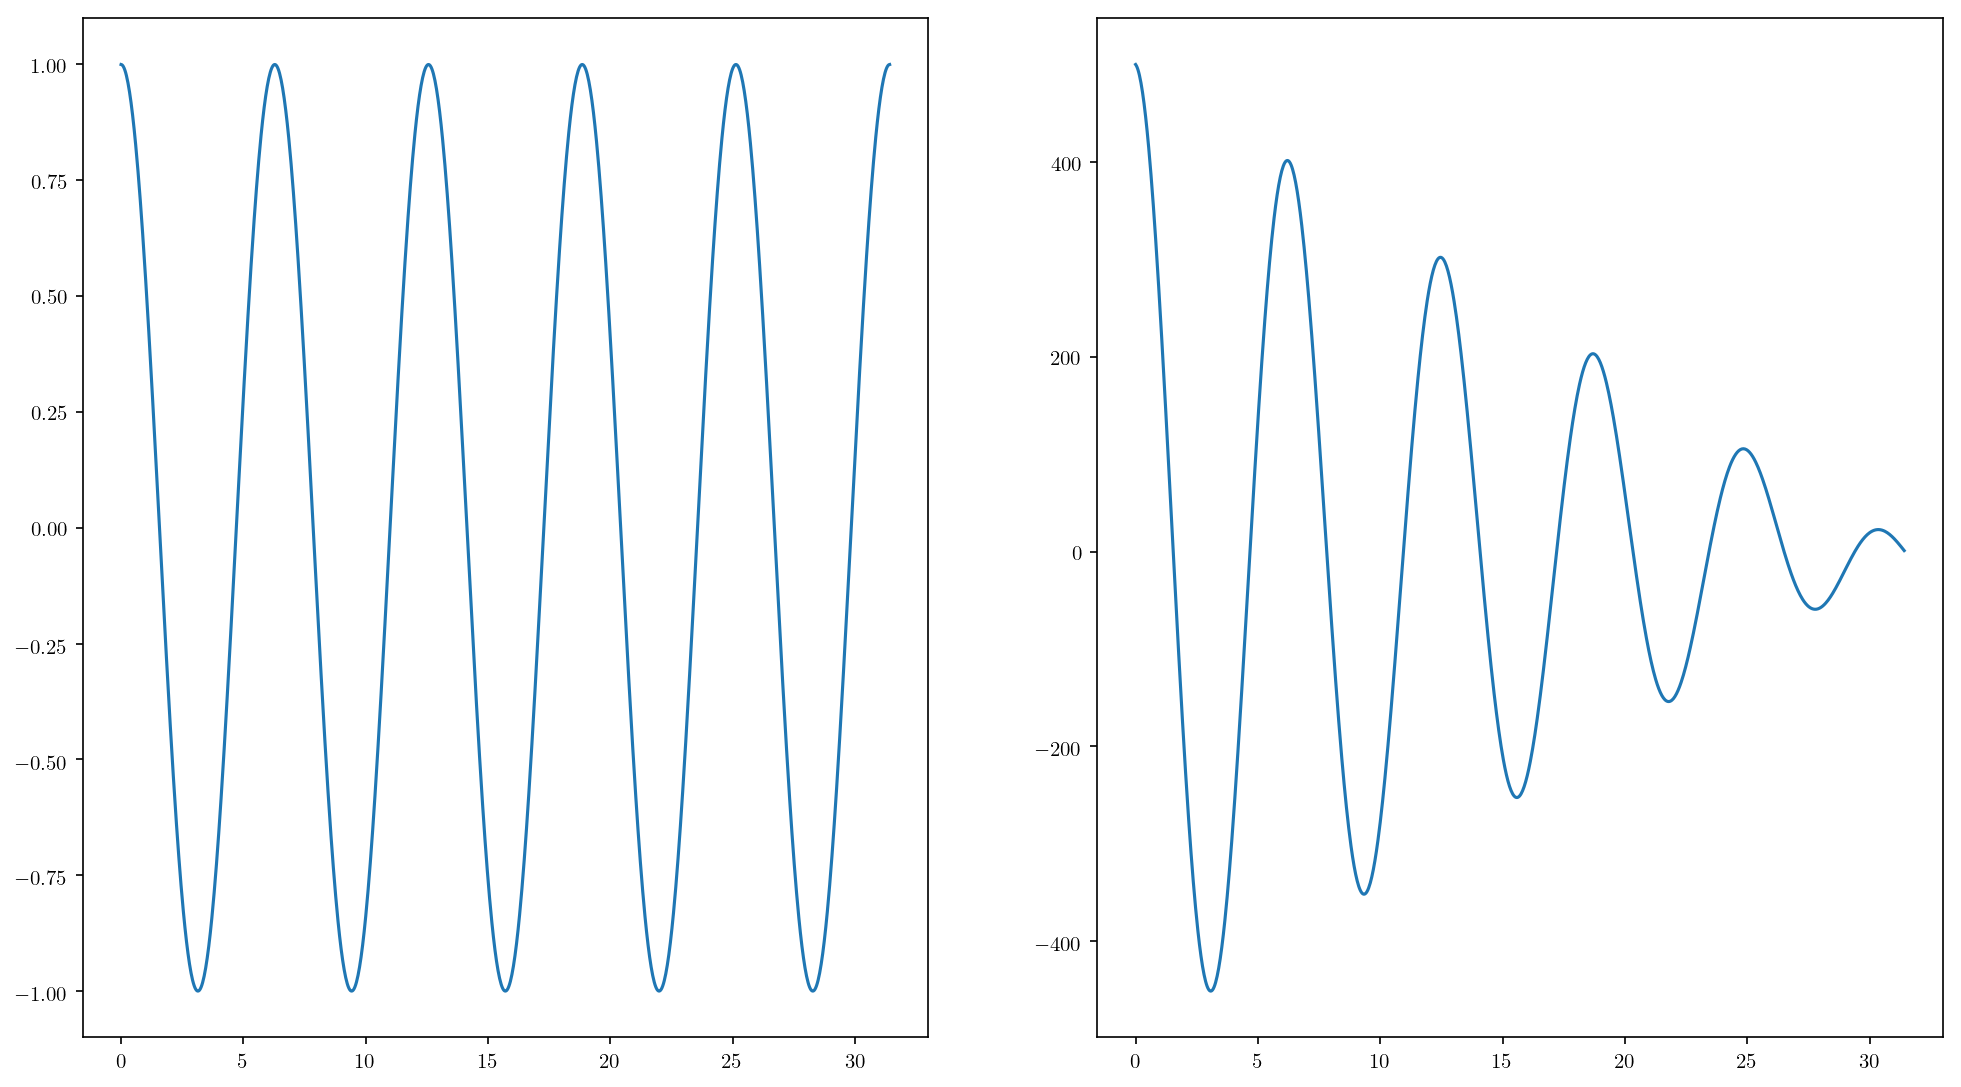

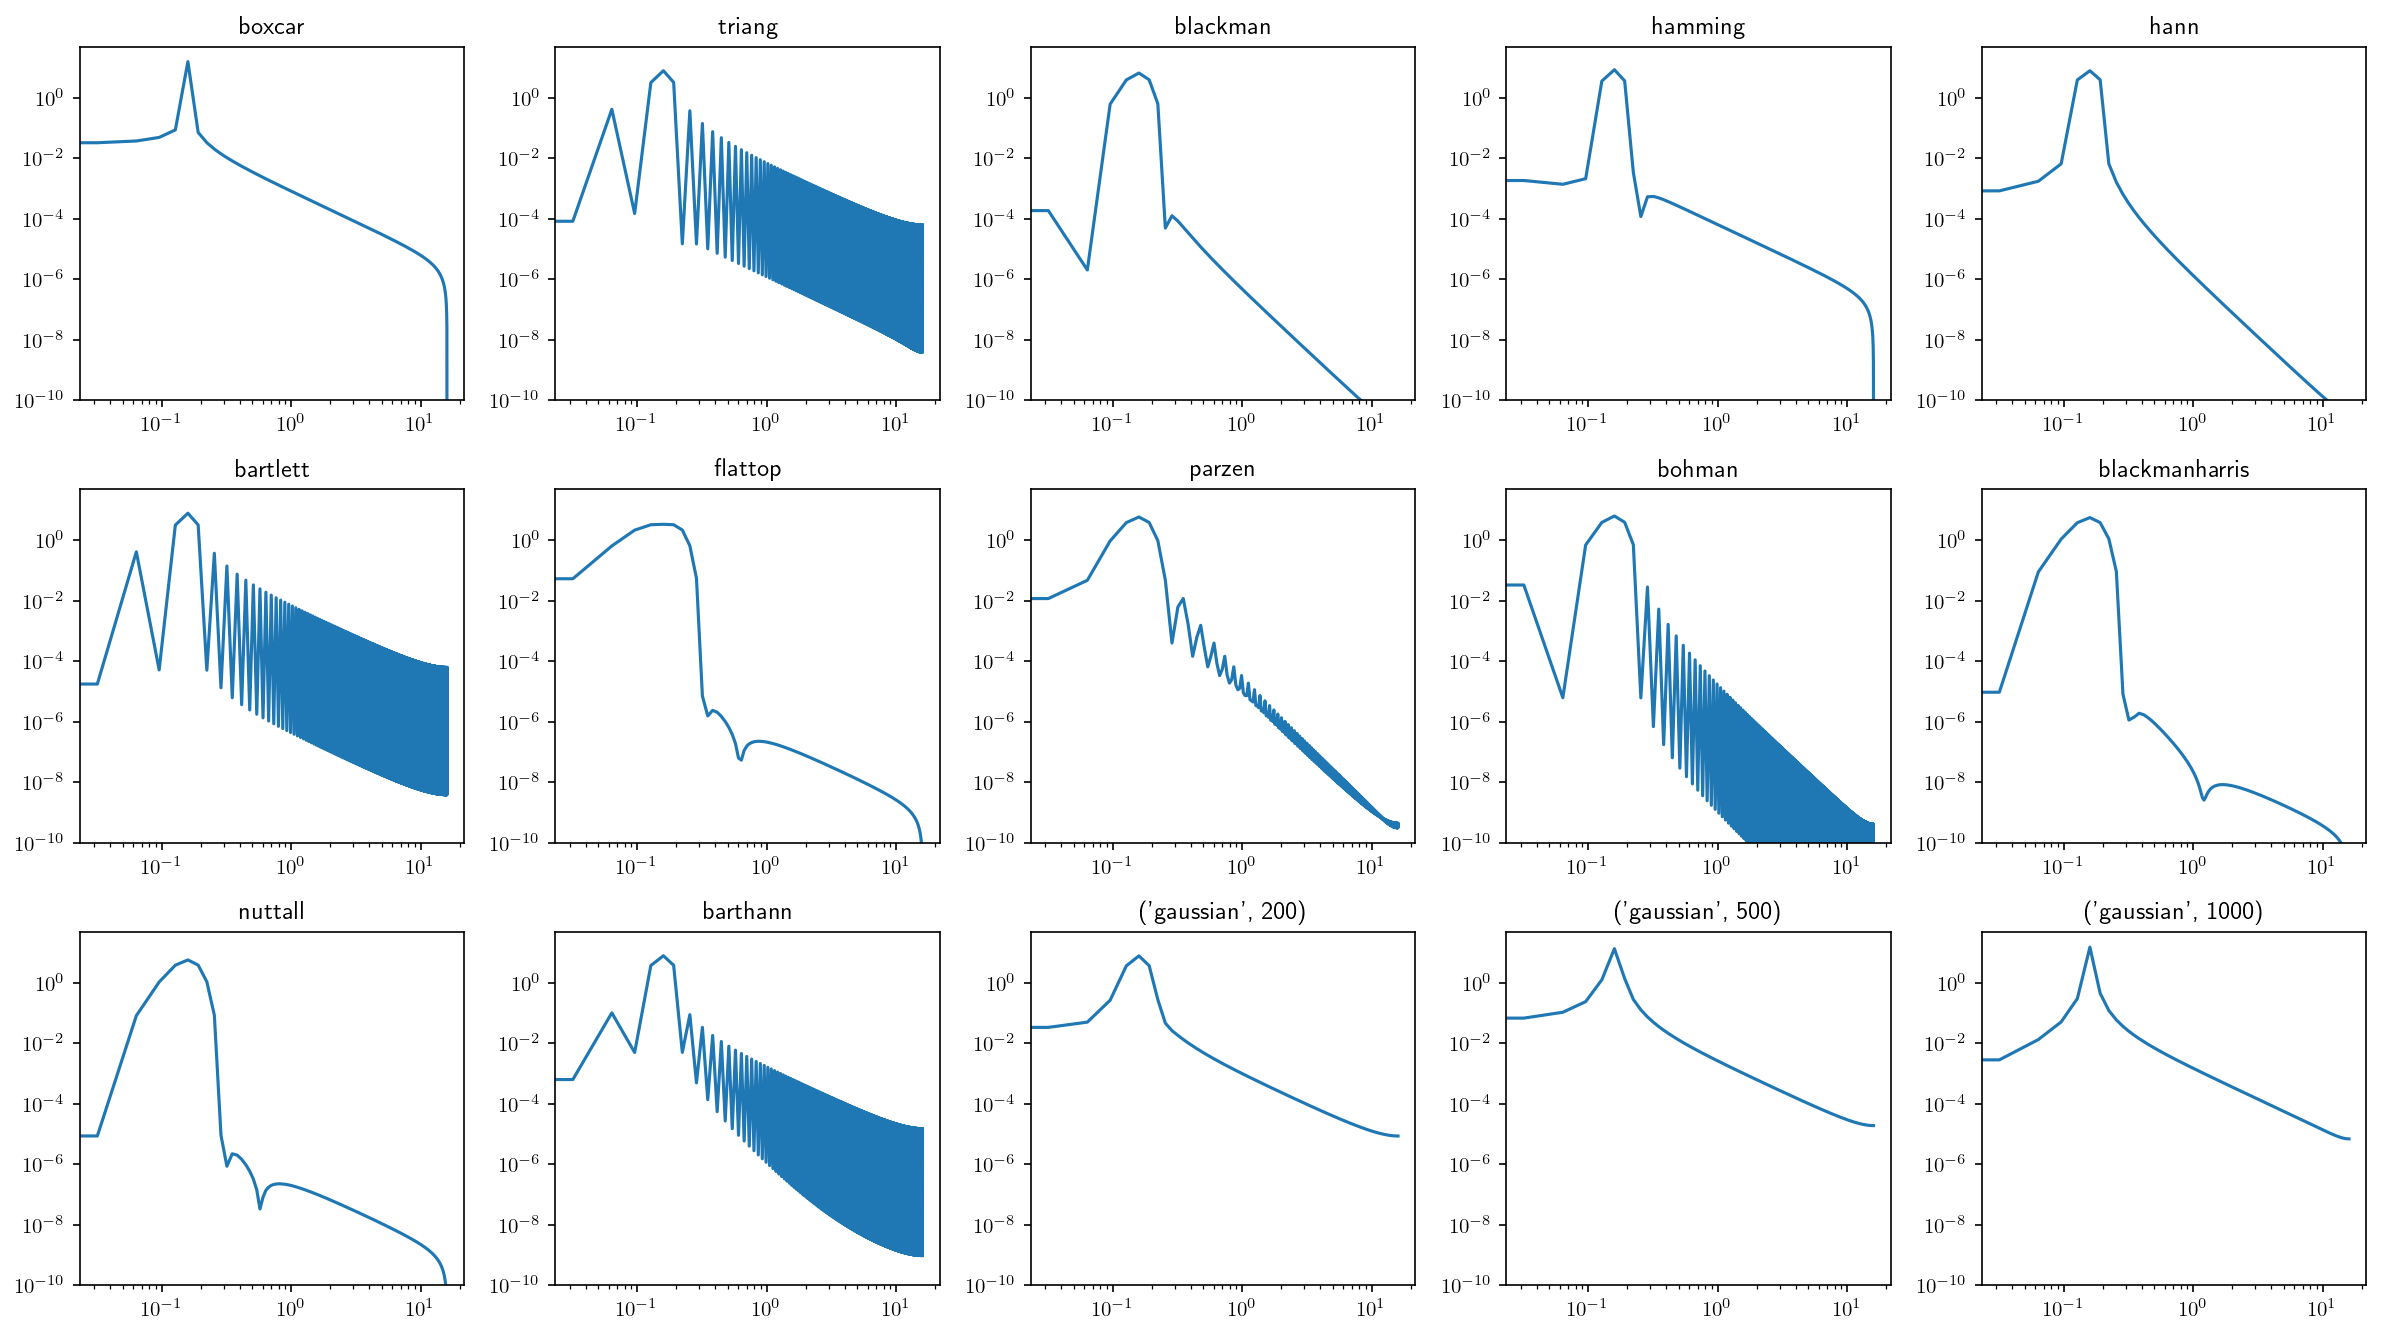

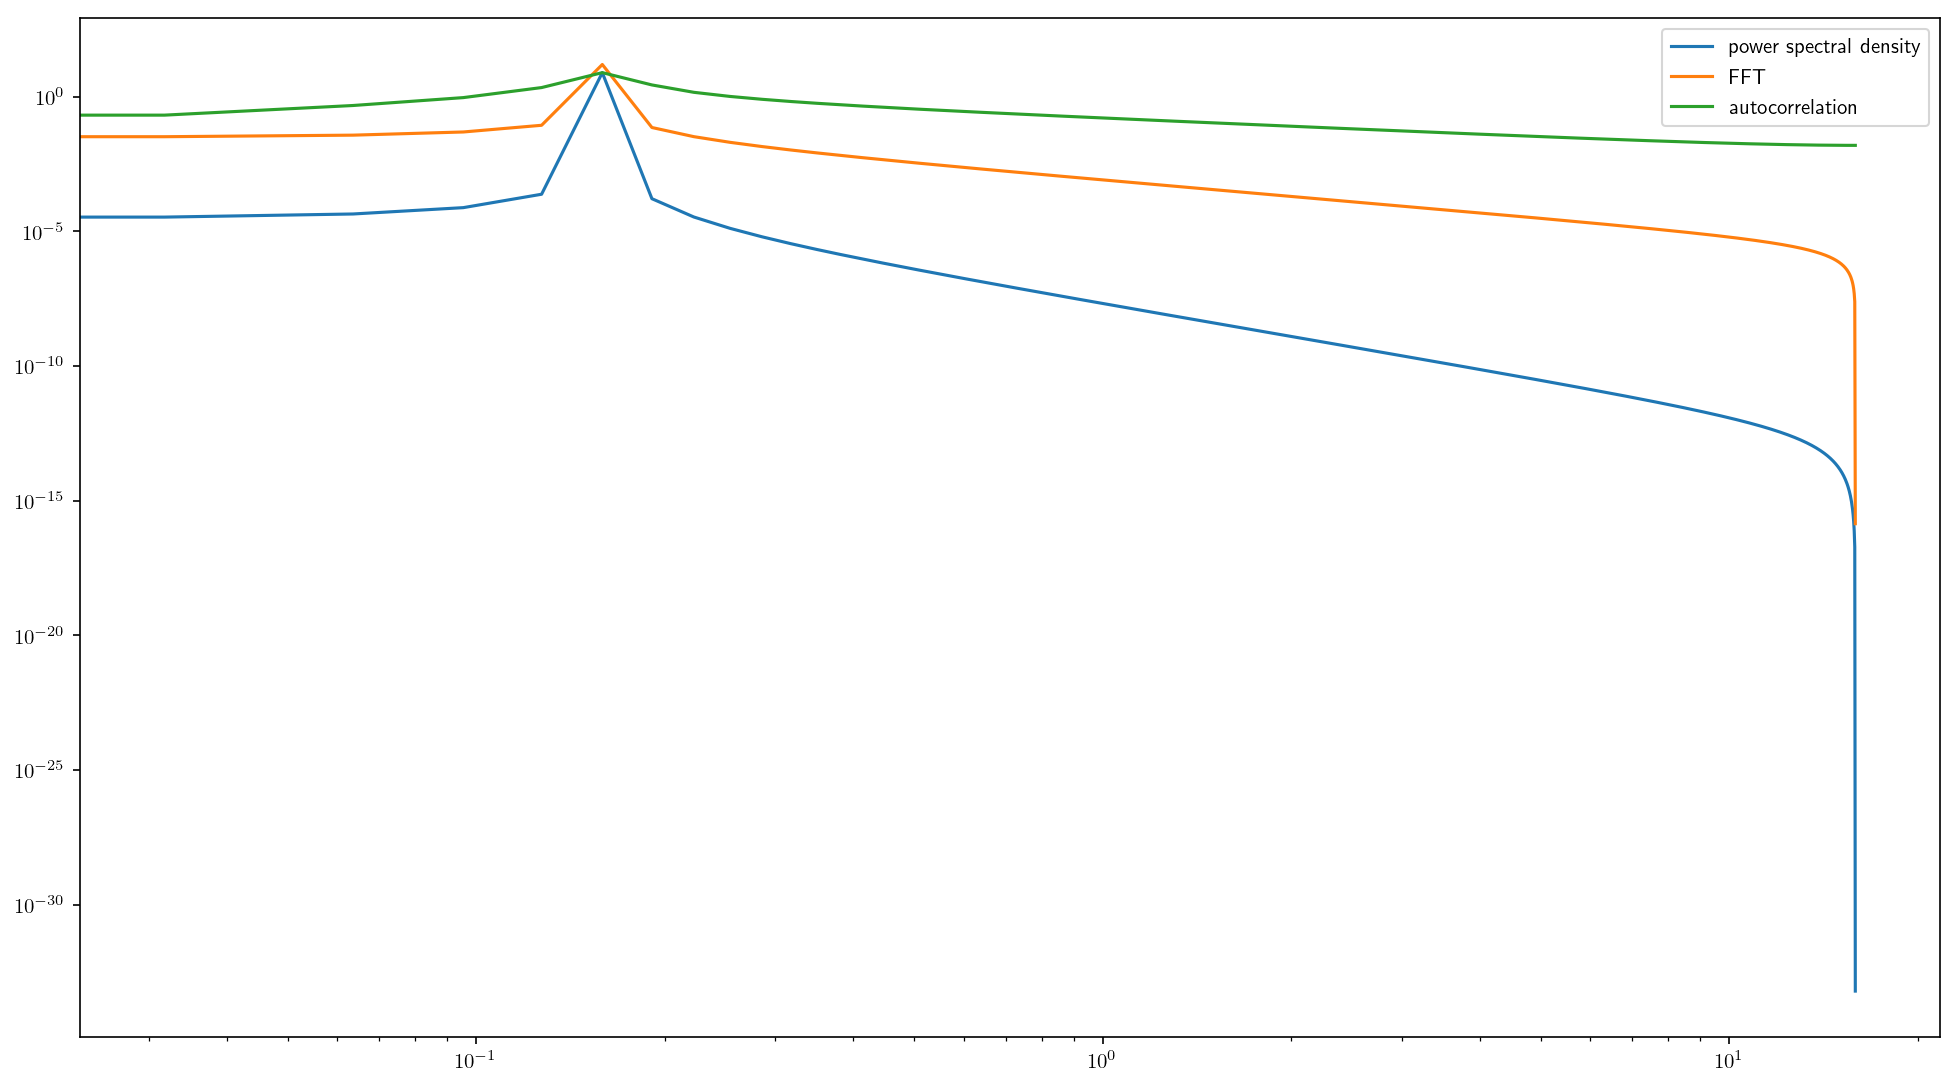

In [8]:
figsize = np.array((16, 9))
dpi = 150
tx = np.linspace(0, 10 * np.pi, 1000)
ty = np.cos(tx)

fig, axs = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
axi = axs[0]
axi.plot(tx, ty)
axi = axs[1]
autocorr_ty = np.correlate(ty, ty, mode='full')[tx.size-1:]
axi.plot(tx, autocorr_ty)

fig, axs = plt.subplots(3, 5, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
win_fun_list = ['boxcar', 'triang', 'blackman', 'hamming', 'hann', 'bartlett', 'flattop', 'parzen', 'bohman', 
                'blackmanharris', 'nuttall', 'barthann', ('gaussian', 200), ('gaussian', 500), ('gaussian', 1000), ]
for win_fun, axi in zip(win_fun_list, axs.ravel()):
    Pxx_den = np.abs(np.fft.rfft(ty * signal.get_window(win_fun, tx.size))) / np.sqrt(tx.size)
    f2 = np.fft.rfftfreq(tx.size, np.mean(np.diff(tx)))
    axi.loglog(f2, Pxx_den, '-')
    axi.set_title(win_fun)
    axi.set_ylim(1e-10, 50)
#     print(Pxx_den.max())
fig.tight_layout()

fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
fs = tx.size / (tx.max() - tx.min())

tfft = np.fft.rfft(ty)
Pxx_den = np.conjugate(tfft) * tfft / tx.size / fs
f2 = np.fft.rfftfreq(tx.size, np.mean(np.diff(tx)))
axi.loglog(f2, Pxx_den.real, '-', label='power spectral density')
# print(np.abs(Pxx_den).max())

Pxx_den = np.abs(np.fft.rfft(ty)) / np.sqrt(tx.size)
f2 = np.fft.rfftfreq(tx.size, np.mean(np.diff(tx)))
axi.loglog(f2, Pxx_den, '-', label='FFT')
# print(np.abs(Pxx_den).max())

Pxx_den = np.abs(np.fft.rfft(np.correlate(ty, ty, mode='full')[tx.size-1:]))
Pxx_den = Pxx_den / tx.size / fs * 2
f2 = np.fft.rfftfreq(tx.size, np.mean(np.diff(tx)))
axi.loglog(f2, Pxx_den, '-', label='autocorrelation')
# print(np.abs(Pxx_den).max())
axi.legend()


0.001398488486247913 0.0014632129184923878


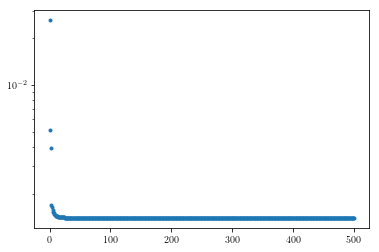

In [102]:
figsize = np.array((16, 9))
dpi = 150
tx = np.linspace(0, 10 * np.pi, 1000)
ty = np.cos(np.random.sample(1) * 2 * np.pi * tx)

# fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
# fig.patch.set_facecolor('white')
# fs = tx.size / (tx.max() - tx.min())

tfft = np.fft.rfft(ty)
Pxx_den = np.abs(np.sqrt(np.conjugate(tfft) * tfft))
f2 = np.fft.rfftfreq(tx.size, np.mean(np.diff(tx)))
# axi.loglog(f2, Pxx_den, '-', label='power spectral density')
# print(np.abs(Pxx_den).max())

# Pxx_den2 = np.abs(np.fft.rfft(ty)).real
# f2 = np.fft.rfftfreq(tx.size, np.mean(np.diff(tx)))
# axi.loglog(f2, Pxx_den2, '-', label='FFT')
# # print(np.abs(Pxx_den).max())

Pxx_den3 = np.abs(np.fft.rfft(np.correlate(ty, ty, mode='full')[tx.size-1:]))
# Pxx_den3 = np.sqrt(Pxx_den3) / tx.size
f2 = np.fft.rfftfreq(tx.size, np.mean(np.diff(tx)))
# axi.loglog(f2, Pxx_den3, '-', label='autocorrelation')
# print(np.abs(Pxx_den).max())
# axi.legend()

plt.semilogy(Pxx_den / Pxx_den3, '.')
print(np.median(Pxx_den / Pxx_den3), np.mean(Pxx_den / Pxx_den3))


0.003989364416160491 0.003989427989474097


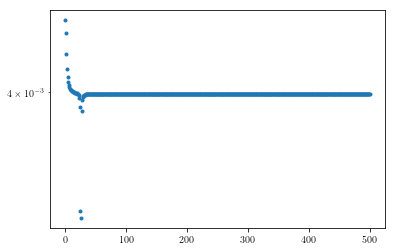

In [83]:
plt.semilogy(Pxx_den / Pxx_den3, '.')
print(np.median(Pxx_den / Pxx_den3), np.mean(Pxx_den / Pxx_den3))
# np.real(Pxx_den / np.sqrt(Pxx_den3 / tx.size))
# 1 / tx.size / fs


## scipy.signal.lombscargle

In [103]:
import scipy.signal as signal


[6.61158282 1.58758555 9.71867693]


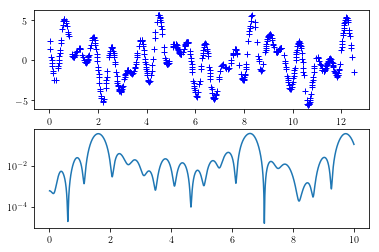

In [223]:
A = 2.
nfre = 3
w = np.random.sample(nfre) * 10
phi = np.random.sample(nfre) * np.pi
nin = 1000
nout = 100000
frac_points = 0.5 # Fraction of points to select

r = np.random.rand(nin)
x = np.linspace(0.01, 4*np.pi, nin)
x = x[r >= frac_points]

y = A * np.sum([np.sin(wi * x + phii) for (wi, phii) in zip(w, phi)], axis=0)
f = np.linspace(0.01, 10, nout)
pgram = signal.lombscargle(x, y, f, normalize=True)

print(w)
plt.subplot(2, 1, 1)
plt.plot(x, y, 'b+')
plt.subplot(2, 1, 2)
plt.semilogy(f, pgram)
plt.show()

## scipy.signal.welch

In [224]:
from scipy import signal


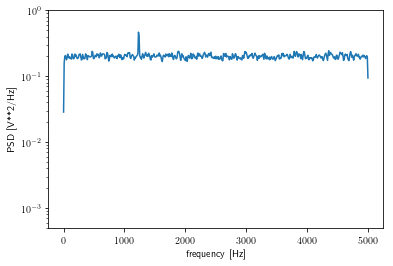

In [232]:
np.random.seed(1234)
fs = 10e3
N = 1e5
amp = 2*np.sqrt(2)
freq = 1234.0
noise_power = 0.2 * fs / 2
time = np.arange(N) / fs
x = amp*np.sin(2*np.pi*freq*time)
x += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)

f, Pxx_den = signal.welch(x, fs, nperseg=1024)
plt.semilogy(f, Pxx_den)
plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()
